In [1]:
%matplotlib inline

# 自動駕駛街景分割(keras+tensorflow)

### 測試於tensorflow 1.10 keras 2.2.2

<img src="../Data/autodrive_train/orign_images/0001TP_006750.png",width=480,height=360>
<img src="../Data/autodrive_train/masks/0001TP_006750_L.png",width=480,height=360>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
import PIL
from PIL import Image
import glob
import threading
import random
import math
import datetime
import numpy as np

import tensorflow as tf
from keras.models import *
from keras.layers import * 
from keras.losses import * 
from keras.callbacks import *
from keras.preprocessing import image
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.applications import * 
from keras.applications.imagenet_utils import *
from keras.utils.np_utils import to_categorical
from keras.optimizers import  Adam
from keras.preprocessing.image import *

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.40
set_session(tf.Session(config=config))

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

Using TensorFlow backend.


In [3]:
images = glob.glob('../Data/autodrive_train/orign_images/' + '*.png')
labels = ['../Data/autodrive_train/masks/' + os.path.basename(i)[:-4] + '_L.png' for i in images]
print(len(images))
print(images[:5])

701
['../Data/autodrive_train/orign_images\\0001TP_006690.png', '../Data/autodrive_train/orign_images\\0001TP_006720.png', '../Data/autodrive_train/orign_images\\0001TP_006750.png', '../Data/autodrive_train/orign_images\\0001TP_006780.png', '../Data/autodrive_train/orign_images\\0001TP_006810.png']


In [4]:
print(open("label_colors.txt").readlines())

['Void\t0 0 0\n', 'Building\t128 0 0\n', 'grass\t0 128 0\n', 'Tree\t128 128 0\n', 'cow\t0 0 128\n', 'horse\t128 0 128\n', 'sheep\t0 128 128\n', 'Sky\t128 128 128\n', 'mountain\t64 0 0\n', 'aeroplane\t192 0 0\n', 'water\t64 128 0\n', 'face\t192 128 0\n', 'Car\t64 0 128\n', 'Archway\t192 0 128\n', 'flower\t64 128 128\n', 'SignSymbol\t192 128 128\n', 'bird\t0 64 0\n', 'book\t128 64 0\n', 'chair\t0 192 0\n', 'motorbike\t128 192 0\n', 'person\t0 64 128\n', 'Road\t128 64 128\n', 'cat\t0 192 128\n', 'dog\t128 192 128\n', 'Pedestrian\t64 64 0\n', 'boat\t192 64 0\n', 'Wall\t64 192 0\n', 'VegetationMisc\t192 192 0\n', 'Fence\t64 64 128\n', 'Train\t192 64 128\n', 'ParkingBlock\t64 192 128\n', 'Column_Pole\t192 192 128\n', 'TrafficCone\t0 0 64\n', 'unused\t128 0 64\n', 'Bridge\t0 128 64\n', 'Misc_Text\t128 128 64\n', 'Sidewalk\t0 0 192\n', 'LaneMkgsDriv\t128 0 192\n', 'Bicyclist\t0 128 192\n', 'RoadShoulder\t128 128 192\n', 'Tunnel\t64 0 64\n', 'LaneMkgsNonDriv\t192 0 64\n', 'Animal\t64 128 64\n',

In [5]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.replace('\t\t','\t').strip().split("\t")
        return tuple(int(i) for i in b.split(' ')), a

label_codes, label_names = zip(*[parse_code(l) for l in open("label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)

for i in range(len(label_codes)):
    print(str(label_codes[i])+' '+label_names[i])

(0, 0, 0) Void
(128, 0, 0) Building
(0, 128, 0) grass
(128, 128, 0) Tree
(0, 0, 128) cow
(128, 0, 128) horse
(0, 128, 128) sheep
(128, 128, 128) Sky
(64, 0, 0) mountain
(192, 0, 0) aeroplane
(64, 128, 0) water
(192, 128, 0) face
(64, 0, 128) Car
(192, 0, 128) Archway
(64, 128, 128) flower
(192, 128, 128) SignSymbol
(0, 64, 0) bird
(128, 64, 0) book
(0, 192, 0) chair
(128, 192, 0) motorbike
(0, 64, 128) person
(128, 64, 128) Road
(0, 192, 128) cat
(128, 192, 128) dog
(64, 64, 0) Pedestrian
(192, 64, 0) boat
(64, 192, 0) Wall
(192, 192, 0) VegetationMisc
(64, 64, 128) Fence
(192, 64, 128) Train
(64, 192, 128) ParkingBlock
(192, 192, 128) Column_Pole
(0, 0, 64) TrafficCone
(128, 0, 64) unused
(0, 128, 64) Bridge
(128, 128, 64) Misc_Text
(0, 0, 192) Sidewalk
(128, 0, 192) LaneMkgsDriv
(0, 128, 192) Bicyclist
(128, 128, 192) RoadShoulder
(64, 0, 64) Tunnel
(192, 0, 64) LaneMkgsNonDriv
(64, 128, 64) Animal
(192, 128, 64) Child
(64, 0, 192) CartLuggagePram
(192, 0, 192) MotorcycleScooter
(64,

In [6]:
img_h =64
img_w = 64
num_classes =len(label_codes)


#開啟圖片，並且縮放至64*64(原圖是960*720)
def open_image(img):
    x=np.array(Image.open(img).resize((img_h,img_w), Image.NEAREST))
    return x

imgs = np.stack([open_image(i) for i in images])
print(imgs.shape)

lbs = np.stack([open_image(l) for l in labels])
print(lbs.shape)

(701, 64, 64, 3)
(701, 64, 64, 3)


In [7]:
#將圖片向量除以255，讓數值介於0~1之間
imgs = imgs/255.

#計算圖片的平均值與標準差
mean = imgs.mean()
std = imgs.std()
print('平均值:{0},標準差:{1}'.format(mean, std))

#圖片根據平均值與標準差正歸化
imgs-=imgs.mean()
imgs/=imgs.std()

平均值:0.4001389752974565,標準差:0.3020399749530272


In [9]:
#產生索引對類別色彩之間的轉換
code2id = {v: k for k, v in enumerate(label_codes)}
id2code = {k: v for k, v in enumerate(label_codes)}
print(len(label_codes))
num_class=len(label_codes)
label_colours = np.asarray(label_codes)
code2id

50


{(0, 0, 0): 0,
 (0, 0, 64): 32,
 (0, 0, 128): 4,
 (0, 0, 192): 36,
 (0, 64, 0): 16,
 (0, 64, 64): 48,
 (0, 64, 128): 20,
 (0, 128, 0): 2,
 (0, 128, 64): 34,
 (0, 128, 128): 6,
 (0, 128, 192): 38,
 (0, 192, 0): 18,
 (0, 192, 128): 22,
 (64, 0, 0): 8,
 (64, 0, 64): 40,
 (64, 0, 128): 12,
 (64, 0, 192): 44,
 (64, 64, 0): 24,
 (64, 64, 128): 28,
 (64, 128, 0): 10,
 (64, 128, 64): 42,
 (64, 128, 128): 14,
 (64, 128, 192): 46,
 (64, 192, 0): 26,
 (64, 192, 128): 30,
 (128, 0, 0): 1,
 (128, 0, 64): 33,
 (128, 0, 128): 5,
 (128, 0, 192): 37,
 (128, 64, 0): 17,
 (128, 64, 64): 49,
 (128, 64, 128): 21,
 (128, 128, 0): 3,
 (128, 128, 64): 35,
 (128, 128, 128): 7,
 (128, 128, 192): 39,
 (128, 192, 0): 19,
 (128, 192, 128): 23,
 (192, 0, 0): 9,
 (192, 0, 64): 41,
 (192, 0, 128): 13,
 (192, 0, 192): 45,
 (192, 64, 0): 25,
 (192, 64, 128): 29,
 (192, 128, 0): 11,
 (192, 128, 64): 43,
 (192, 128, 128): 15,
 (192, 128, 192): 47,
 (192, 192, 0): 27,
 (192, 192, 128): 31}

In [10]:
#轉換單張標籤為mask(64*64*3->64*64*50)
def conv_one_label(b_label,num_class=50):
    res = np.zeros((b_label.shape[0],b_label.shape[1],num_class), 'float32')
    for j in range(b_label.shape[0]):
        for k in range(b_label.shape[1]):
            color=tuple(b_label[j,k,:].tolist())
            if color in code2id:
                try:
                    res[j, k,code2id[color]] = 1
                except Exception as e:
                    print(e)
                    print(code2id[color])
                    print(color)
                    res[j, k,0] = 1
            else:
                res[j, k,0] = 1
    
    return res



lbs = np.array([conv_one_label(open_image(l)) for l in labels])
lbs =np.reshape(lbs,(701,-1,50))
print(lbs.shape)

(701, 4096, 50)


In [11]:
#將向量轉圖片
def array2img(arr: np.ndarray):
    sanitized_img =arr
    if len(arr.shape) > 2:
        sanitized_img = np.maximum(0, np.minimum(255, arr))
        img = Image.fromarray(sanitized_img.astype(np.uint8))
        return img
    elif  len(arr.shape) == 2:
        img = Image.fromarray(arr.astype(np.int8))
        return img

#將mask轉RGB圖片(批次*64*64*50=>批次*64*64*3)
def decode_labels(masks, num_classes=50):
    global img_w, img_h
    result = []
    for batch in range(masks.shape[0]):
        decode_map = masks[batch]
        decode_map = np.argmax(decode_map, -1).astype(np.float32)
        color_img = np.zeros((img_h, img_w, 3), dtype=np.float32)# * 192
        for k in range(num_classes):
            if k > 0:
                color_img[decode_map == k] = label_colours[k]
        result.append(color_img)
    return np.asarray(result)

#把圖片並列列印出來
def tile_rgb_images(pred, label, truth, row=3, col=3):
    fig = pylab.gcf()
    fig.set_size_inches(col * 2, row * 2)
    pylab.clf()
    pylab.ioff()  # is not None:
    for m in range(row * col):
        pylab.subplot(row, col, m + 1)
        if m % 3 == 0:
            if pred.shape[0] == 1:
                pred = pred[0]
            img = array2img(pred[int(m / 3)]).resize((240,180))
        elif m % 3 == 1:
            if label.shape[0] == 1:
                label = label[0]
            img = array2img(label[int((m - 1) / 3)]).resize((240,180))
        else:
            if truth.shape[0] == 1:
                truth = truth[0]
            img = array2img((truth[int((m - 2) / 3)] * std + mean) * 255).resize((240,180))
        pylab.axis("off")
        pylab.imshow(img, interpolation="nearest", animated=True)
        
    

(64, 64, 3)


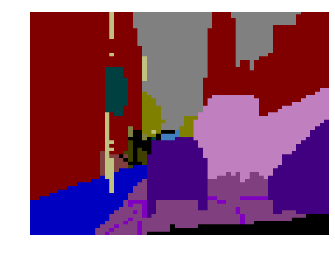

In [14]:
label=open_image(labels[0])
print(label.shape)
img=Image.fromarray(label.astype(np.uint8))
img=img.resize((960,720))
plt.axis("off")
plt.imshow(img)

(64, 64, 50)
(1, 64, 64, 3)


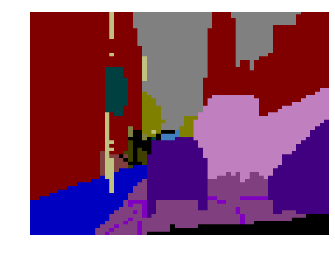

In [15]:
mask=conv_one_label(label,num_class)
print(mask.shape)
rgb_label=decode_labels(np.asarray([mask]),num_class)
print(rgb_label.shape)
img=Image.fromarray(rgb_label[0].astype(np.uint8))
img=img.resize((960,720))
plt.axis("off")
plt.imshow(img)

![autodrive](../Images/tiramisu.jpg)

In [16]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization()(x)
def relu_bn(x): return relu(bn(x))





def conv(x, nf, sz, p, strides=1): 
    x = Conv2D(nf, (sz, sz), strides=strides, padding = "same", kernel_initializer = "he_uniform")(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3,  p=0, strides=1): 
    return conv(relu_bn(x), nf, sz, p=p, strides=strides)



def conv_relu_bn(x, nf, sz=3, p=0, strides=1): 
    return conv(relu_bn(x), nf, sz, p=p, strides=strides)

def dense_block(n,x,growth_rate,p):
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p)
        x = Concatenate(axis=-1)([x, b])
    return x

def transition_dn(x,n_filters, p=0.2):
    return conv_relu_bn(x, n_filters, sz=3, p=p, strides=2)

def down_path(x, nb_layers, growth_rate, p):
    skips = []
    for i,n in enumerate(nb_layers):
        x= dense_block(n,x,growth_rate,p)
        #print('dense_block:{0}'.format(x.shape))
        skips.append(x)
        if i < len(nb_layers) - 1:
            n_filters=nb_layers[i]*growth_rate
            x = transition_dn(x,n_filters, p=p)
    return skips, x



def transition_up(x,n_filters):
    return Conv2DTranspose(n_filters,(3, 3),strides=(2, 2),padding = "same", kernel_initializer = "he_uniform")(x)


def up_path(x, skips, nb_layers, growth_rate, p):
    for i,n in enumerate(nb_layers):
        n_filters=nb_layers[i]*growth_rate
        x = transition_up(x,n_filters)
        x = Concatenate(axis=-1)([x,skips[i]])
        x = dense_block(n,x,growth_rate,p)
        #print('dense_block:{0}'.format(x.shape))
    return x




def reverse(a): return list(reversed(a))


def create_tiramisu(nb_classes, img_input, nb_dense_block=6, growth_rate=16, nb_filter=32, nb_layers_per_block=[4,5,7,10,12], p=0.):
    nb_layers = list(nb_layers_per_block)
    x = conv(img_input, nb_filter, 3,0)
    skips,x = down_path(x, nb_layers, growth_rate, p)
    x =  up_path(x, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate,p)
    x =conv(x, nb_classes, 1, 0)
    x =Reshape((-1,50))(x)
    #x=Permute((2, 1))(x)
    x=Activation('softmax')(x)
    return x


In [18]:
input_shape = (img_h,img_w,3)
img_input = Input(shape=input_shape)
x = create_tiramisu(50, img_input, nb_layers_per_block=[4,5,7,10,12], p=0.2)


model = Model(img_input, x)
model.compile(loss="categorical_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])
model.summary()
model.fit(imgs,lbs,batch_size=16,epochs=10)

dense_block:(?, 64, 64, 96)
dense_block:(?, 32, 32, 144)
dense_block:(?, 16, 16, 192)
dense_block:(?, 8, 8, 272)
dense_block:(?, 4, 4, 352)
dense_block:(?, 8, 8, 592)
dense_block:(?, 16, 16, 416)
dense_block:(?, 32, 32, 304)
dense_block:(?, 64, 64, 224)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 64, 64, 32)   128         conv2d_71[0][0]                  
_____________________________________________________

(3, 64, 64, 50)


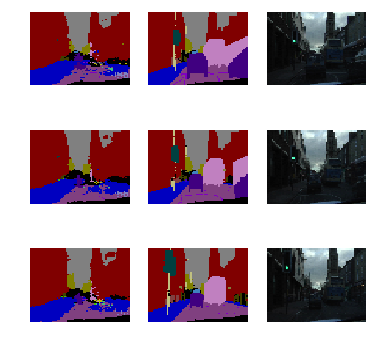

In [22]:
preds = np.reshape(model.predict(imgs[:3,:,:]),(3,64,64,50))
print(preds.shape)
e1 = decode_labels(preds, 50).astype(np.uint8)
l1 = decode_labels(np.reshape(lbs[:3,:,:],(3,64,64,50)), num_classes).astype(np.uint8)
tile_rgb_images(e1, l1,imgs[:3,:,:,:], row=3, col=3)